<a href="https://colab.research.google.com/github/MeysamAmirsardari/PoseModel/blob/main/Jupyter%20Notebook/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations:

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Mount your Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports:

In [3]:
import torch_geometric
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
#from torch_geometric.data import HeteroData

In [4]:
import numpy as np
import torch
import pandas as pd

In [5]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Loading the data:

In [6]:
!git clone https://github.com/MeysamAmirsardari/PoseModel

Cloning into 'PoseModel'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 143 (delta 32), reused 37 (delta 11), pack-reused 57
Receiving objects: 100% (143/143), 9.55 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [7]:
path = '/content/PoseModel/Datasets/Test.csv'

df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
temp = df.head(1).values.tolist()[0]
labels = []
for i in range(1, 54, 3):
  labels.append(temp[i])

df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))

<ipython-input-7-587cd7d3e70e>:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
<ipython-input-7-587cd7d3e70e>:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))


# Modeling the graph:

In [ ]:
Xs = []
Ys = []
CLs = []

for l in labels:
  Xs.append(df[l].values.astype(float).tolist())
  Ys.append(df[l+'.1'].values.astype(float).tolist())
  CLs.append(df[l+'.2'].values.astype(float).tolist())

Xs = np.array(Xs)
Ys = np.array(Ys)
CLs = np.array(CLs)

weighted_mean = np.sum(Xs * CLs, axis=1) / np.sum(CLs, axis=1)
norm_Xs = (Xs - weighted_mean[:, np.newaxis])/350

weighted_mean = np.sum(Ys * CLs, axis=1) / np.sum(CLs, axis=1)
norm_Ys = (Ys - weighted_mean[:, np.newaxis])/720

In [ ]:
# from sklearn.feature_selection import mutual_info_regression

# mi_matrix_X = np.zeros((18, 18))
# mi_matrix_Y = np.zeros((18, 18))
# mi_matrix_CL = np.zeros((18, 18))

# for i in range(18):
#     for j in range(i+1, 18):
         
#         mi_X = mutual_info_regression(norm_Xs[i], norm_Xs[j], discrete_features=False)
#         mi_Y = mutual_info_regression(norm_Ys[i], norm_Ys[j], discrete_features=False)
#         mi_CL = mutual_info_regression(CLs[i], CLs[j], discrete_features=False)
        
#         mi_matrix_X[i, j] = mi_X
#         mi_matrix_X[j, i] = mi_X
#         mi_matrix_Y[i, j] = mi_Y
#         mi_matrix_Y[j, i] = mi_Y
#         mi_matrix_CL[i, j] = mi_CL
#         mi_matrix_CL[j, i] = mi_CL
        

In [9]:
Xs_cov = np.corrcoef(Xs)
Ys_cov = np.corrcoef(Ys)
edj_attr_matrix = (np.square(Ys_cov) + np.square(Xs_cov))/2
print(edj_attr_matrix.astype(np.double))

[[1.         0.94908408 0.93980903 0.59991523 0.63946063 0.83034849
  0.8252035  0.81355121 0.66410295 0.77634551 0.76065985 0.55054154
  0.52658398 0.19743987 0.61739548 0.60999778 0.55439148 0.97429513]
 [0.94908408 1.         0.91523518 0.6064785  0.62418186 0.85539316
  0.7936268  0.82862571 0.65117483 0.78389374 0.72775083 0.56115346
  0.53050381 0.21021096 0.61623938 0.62219154 0.56390192 0.94811628]
 [0.93980903 0.91523518 1.         0.57469535 0.68651147 0.78977271
  0.83532133 0.78939006 0.67783015 0.74203745 0.7390282  0.54836145
  0.54049349 0.18287964 0.62865023 0.59622682 0.56333622 0.93633492]
 [0.59991523 0.6064785  0.57469535 1.         0.39510826 0.53528559
  0.55246602 0.56708888 0.49906882 0.53126238 0.50434884 0.44704423
  0.43125568 0.06306662 0.46894976 0.47590327 0.439365   0.60676342]
 [0.63946063 0.62418186 0.68651147 0.39510826 1.         0.59128252
  0.66602965 0.6043194  0.54196246 0.55608053 0.55982752 0.46248744
  0.4699478  0.20170219 0.53835368 0.4472887

In [10]:
def set_nodes(Xs, Ys, CLs, off_idx, land_mark_num, epoch_len, encoders=None):
  x = torch.tensor([])

  for n in range(epoch_len):
    for i in range(land_mark_num):
      step = torch.tensor([[float(Xs[i, n + off_idx])], 
                           [float(Ys[i, n + off_idx])], 
                           [float(CLs[i, n + off_idx])]], 
                          dtype=torch.float)
      x = torch.cat((x, step.T), dim=0)
  return x

In [11]:
num_landmarks = 18
num_layers = 120
edge_index = []
edge_attr = []

# Connect each landmark to all other landmarks in the same layer
for layer in range(num_layers):
    start = layer * num_landmarks
    layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
    layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
    edge_index.extend(layer_edges)
    edge_attr.extend([edj_attr_matrix[i % num_landmarks, j % num_landmarks] for i, j in layer_edges])

# Connect each landmark to the same landmark in the next layer
for layer in range(num_layers - 1):
    start1 = layer * num_landmarks
    start2 = (layer + 1) * num_landmarks
    layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
    edge_index.extend(layer_edges)
    edge_attr.extend([1 for _ in layer_edges])
    
edge_index = torch.tensor(edge_index).double().t().contiguous()
edge_attr = torch.tensor(edge_attr).unsqueeze(-1)


In [12]:
epoch_len = 120
land_mark_num = 18
len = df.shape[0]-1
overlap = 0.5
graph_list = []
order = []
count = 0
step = 10

#edge_index, edge_attr = set_edges(epoch_len, land_mark_num)

for i in range(1, len-epoch_len, step):
  x = set_nodes(norm_Xs, norm_Ys, CLs, i, land_mark_num, epoch_len)
  data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
  graph_list.append(data)
  count = count + 1
  order.append((count, i))

graph_num = count

* **Create and save the dataset:**

In [ ]:
loader = DataLoader(graph_list, batch_size=16)
torch.save(loader, '/content/drive/MyDrive/Test_loader_for_step10.pth')

pd.DataFrame(order).to_csv('/content/drive/MyDrive/order.csv')

In [ ]:
from torch_geometric.data import InMemoryDataset

dataset = InMemoryDataset(root='/content/', transform=None)
dataset.data = graph_list
dataset.index_select = None

# Save the dataset to disk
torch.save(dataset, './dataset.pt')

# Load the dataset from disk
dataset2 = torch.load('./dataset.pt')

# Print the first data object in the dataset
print(dataset2[0])

[Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 

In [ ]:
import os.path as osp
from torch_geometric.data import Dataset, download_url

root = '/content/drive/MyDrive/Test_loader.pth'

class Dataset1(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [ ]:
dataloader = DataLoader(dataset, batch_size=16)

# Training the Attentional Variational Graph Autoencoder:

**- At first you just need to choose and load one the following Encoders:**

**Model: MultiHead Transormer**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.multihead_attn1 = TransformerConv(input_dim, hidden_dim,
                                               concat=False, heads=4, dropout=0.4)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.multihead_attn2 = TransformerConv(hidden_dim, hidden_dim, 
                                               concat=False, heads=4, dropout=0.4)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        self.gat4 = GATConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)

        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x1 = self.multihead_attn1(x, edge_index)
        # x1 = torch.cat([x1, x], dim=-1)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)
        # x1 = F.dropout(x1, p=0.4, training=self.training)
        
        x2 = self.multihead_attn2(x1, edge_index)
        # x2 = torch.cat([x2, x1], dim=-1)
        x2 = self.bn2(x2+x1)
        x2 = F.elu(x2)
        # x2 = F.dropout(x2, p=0.4, training=self.training)
        
        x3 = self.gat3(x2, edge_index, edge_attr=edge_attr)
        # x3 = torch.cat([x3, x2], dim=-1)
        x3 = self.bn3(x3+x2)
        x3 = F.elu(x3)
        x3 = F.dropout(x3, p=0.4, training=self.training)

        x4 = self.gat4(x3, edge_index, edge_attr=edge_attr)
        x4 = self.bn4(x4+x3)
        x4 = F.elu(x4)
        x4 = F.dropout(x4, p=0.4, training=self.training)

        x = self.conv_mu(x4, edge_index)
        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

**Encoder: GAT-50**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        # self.gmm_layers = torch.nn.ModuleList()
        # for i in range(num_gmm_layers):
        #     self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=25, dim=3))
        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # for gmm_layer in self.gmm_layers:
        #     x = gmm_layer(x, edge_index, edge_attr)
        #     x = F.elu(x)
        #     x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)
        
        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std


**Encoder: GAT+bn+sp**

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np


# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, 64)
        self.gat2 = GATConv(64, 128)
        self.gat3 = GATConv(128, 256)
        # self.gmm_layers = torch.nn.ModuleList()
        # for i in range(num_gmm_layers):
        #     self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=25, dim=3))
        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # for gmm_layer in self.gmm_layers:
        #     x = gmm_layer(x, edge_index, edge_attr)
        #     x = F.elu(x)
        #     x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)
        
        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std


**Decoder and Loss Func:**

In [17]:
class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

def loss_function(x_hat, z_mean, x, z_log_std):
    # kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    kl_loss = -0.5 * torch.sum(1 + z_log_std - z_mean.pow(2) - z_log_std.exp())
    recon_loss = F.mse_loss(x_hat, x)
    print(kl_loss)
    print(recon_loss)
    loss = recon_loss + 0.1*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


**Training the model:**

In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []


# Define the number of epochs to train for
num_epochs = 50

# Define the batch size for the dataloader
batch_size = 32

# Define the number of nodes and features in each node
num_nodes = 2160
num_features = 3

# Define the number of dimensions in the latent variable
hidden_dim = 256
output_dim = 256
input_dim = 3

dataloader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        x_hat, z_mean, z_log_std = model(batch.x, batch.edge_index.long(), batch.edge_attr, batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        loss = F.mse_loss(x_hat, batch.x)
        # print(loss)
        # print(kl_loss(z_mean, z_log_std))
        loss = loss + 0.1 * kl_loss(z_mean, z_log_std)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= graph_num
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


**Cleaning the memory!**

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

# Evaluation:

In [ ]:
output = model.encoder(graph_list[0].x, graph_list[0].edge_index.long(), graph_list[0].edge_attr, graph_list[0].batch)

In [ ]:
output[0].shape

torch.Size([1, 6])

In [ ]:
model.eval()

AttentionalGraphAutoencoder(
  (encoder): Encoder(
    (gat1): GATConv(3, 24, heads=1)
    (gat2): GATConv(24, 24, heads=1)
    (gat3): GATConv(24, 24, heads=1)
    (conv_mu): GCNConv(24, 24)
    (lin): Linear(in_features=24, out_features=16, bias=True)
    (lin_mean): Linear(in_features=24, out_features=16, bias=True)
    (lin_logstd): Linear(in_features=24, out_features=16, bias=True)
    (global_pool): Linear(in_features=24, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=16, out_features=24, bias=True)
    (conv1): GCNConv(24, 24)
    (conv2): GCNConv(24, 24)
    (lin2): Linear(in_features=24, out_features=24, bias=True)
    (conv3): GCNConv(24, 24)
    (lin3): Linear(in_features=24, out_features=3, bias=True)
  )
)

**To save the trained model:**

In [ ]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/SocioSent/my_model.pt')

**Loading the saved model:**

In [ ]:
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Load the saved state dictionary into the model
state_dict = torch.load('/content/drive/MyDrive/SocioSent/my_model4.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

# Embedding the graphs and saving:

In [ ]:
# Embed the input graphs using the trained VAE
embeddings = []

for graph in graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.edge_attr, graph.batch)
    embeddings.append(output[0].cpu().numpy())

embeddings = np.array(embeddings)

In [ ]:
np.save('/content/drive/MyDrive/embeddings_multihead.npy', embeddings)

Reload:

In [ ]:
embeddings = np.load('/content/drive/MyDrive/SocioSent/embeddings2.npy')
# embedded_3d = np.load('/content/drive/MyDrive/node_embeddings_3D.npy')

In [ ]:
embeddings2 = np.array(embeddings[:,0,:])

Visualizing the embedded data:

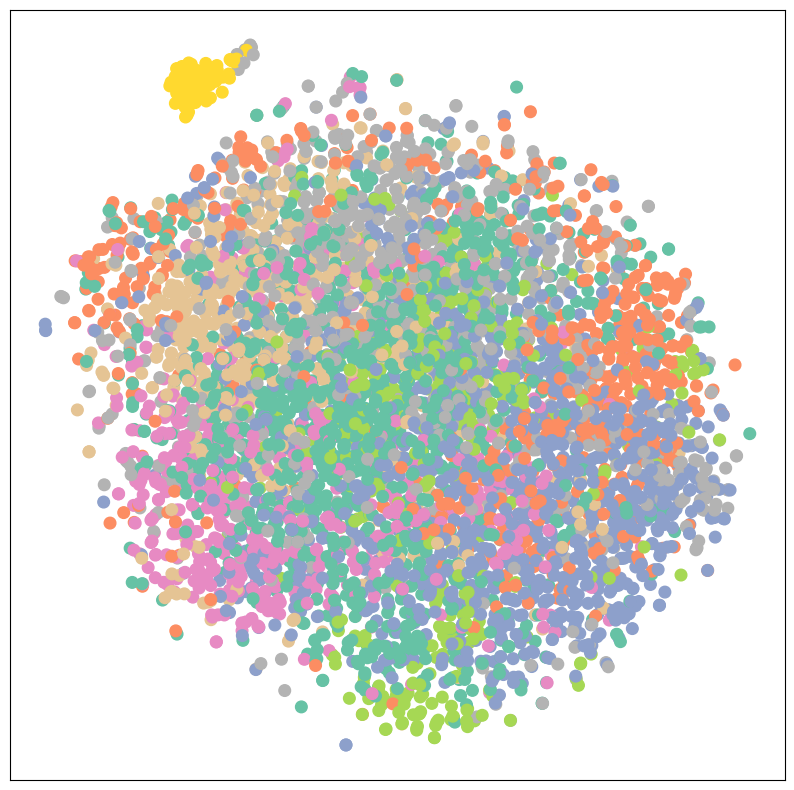

In [ ]:
visualize(torch.tensor(embeddings2), color=np.zeros([1,graph_num]))

# Clustering the Graphs:

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 10

# Initialize the GMM model
gmm = GaussianMixture(n_components=num_clusters)

# Fit the GMM model to the embedded data
gmm.fit(embeddings2)

# Predict the cluster labels for the embedded data
cluster_labels = gmm.predict(embeddings2)
print(cluster_labels)

In [ ]:
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import hdbscan

# Assuming your 6x1000 array is called `embedded_graph`
# Transpose the array so that each row represents a data point and each column represents a feature
embedded_graph = embeddings2

# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels2 = clusterer.fit_predict(embedded_graph)

# Print the number of clusters found
# num_clusters = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print(f"Number of clusters: {num_clusters}")

# Print the cluster labels for each data point
print("Cluster labels:")
print(cluster_labels2)

Number of clusters: 8
Cluster labels:
[-1 -1  9  9  9  9 -1 -1 -1 -1 -1 -1 -1 -1  5  6  5 -1 -1 -1 -1  3 -1  9
 -1 -1  9  9 -1 -1  5  5 -1  3 -1 -1  9  6 -1 -1 -1 -1  1  1  1  1  1  1
  2  6  5  5 -1 -1  2 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  5  3 -1 -1 -1  9
  9  9  9 -1 -1 -1 -1 -1  9  9 -1  3  1 -1 -1  2 -1 -1 -1 -1 -1 -1  9  9
  9  9 -1  3 -1  4  3  3 -1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1  9  9  9 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1
  5  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  4 -1  9  9  9  9  9  9  9
 -1 -1 -1 -1  3  4  9 -1  3  3  3 -1 -1 -1 -1 -1 -1  6  6  6  6  5  5  5
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9  9  9  9  9  9  9  9  9
  9  9  9  9 -1  3  1  2  2 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  5 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1  3 -1 -1 -1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1
  5 -1  9  9  9 -1  9  9  9 -1 -1  9  9  9 -1 -1  2 -1 -1 -1 -1 -1 -1 -1
 -1  1  1  1 

In [ ]:
visualize(torch.tensor(embeddings2), color=cluster_labels)

# Analysis:

transition matrix:

In [ ]:
states = cluster_labels
# Get unique state values
unique_states = np.unique(cluster_labels)

# Calculate the size of the transition matrix
matrix_size = 8

# Create an empty transition matrix
transition_matrix = np.zeros((matrix_size, matrix_size))

# Calculate the number of transitions between each pair of states
for i in range(graph_num - 1):
    current_state = states[i]
    next_state = states[i + 1]
    current_state_index = np.where(unique_states == current_state)[0][0]
    next_state_index = np.where(unique_states == next_state)[0][0]
    transition_matrix[current_state_index][next_state_index] += 1

# Normalize the transition matrix
row_sums = np.sum(transition_matrix, axis=1)
transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis])

print(transition_matrix)

[[0.63265306 0.         0.         0.02040816 0.02040816 0.02040816
  0.02040816 0.28571429]
 [0.         0.89971347 0.         0.08022923 0.00286533 0.
  0.01719198 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.00649351 0.19480519 0.         0.51298701 0.         0.
  0.26623377 0.01948052]
 [0.         0.         0.07692308 0.         0.76923077 0.
  0.         0.15384615]
 [0.00826446 0.         0.         0.         0.         0.75206612
  0.23966942 0.        ]
 [0.02469136 0.02469136 0.         0.27160494 0.         0.17283951
  0.4691358  0.03703704]
 [0.19672131 0.         0.         0.03278689 0.01639344 0.01639344
  0.14754098 0.59016393]]


histogram:

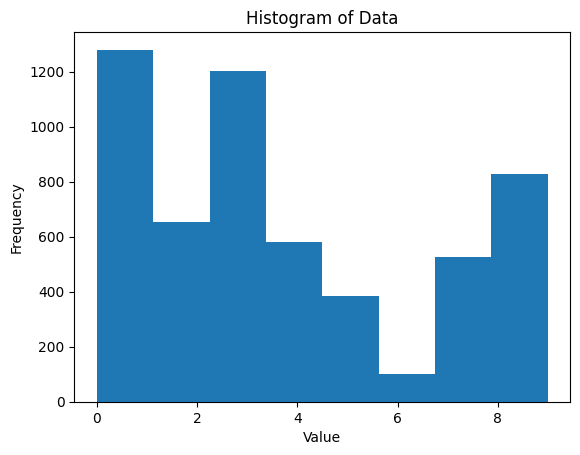

In [ ]:
plt.hist(cluster_labels, bins=8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

transition graph:

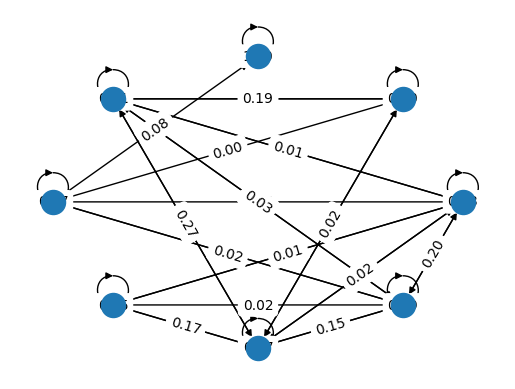

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# define the transition matrix
P = transition_matrix

# create a directed graph
G = nx.DiGraph()

# add nodes to the graph
for i in range(P.shape[0]):
    G.add_node(i)

# add edges to the graph
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i,j] > 0:
            G.add_edge(i, j, weight=P[i,j])

# set the positions of the nodes in the graph
pos = nx.circular_layout(G)

# draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# add edge labels to the graph
edge_labels = {(i, j): "{:.2f}".format(P[i,j]) for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# display the graph
plt.axis("off")
plt.show()


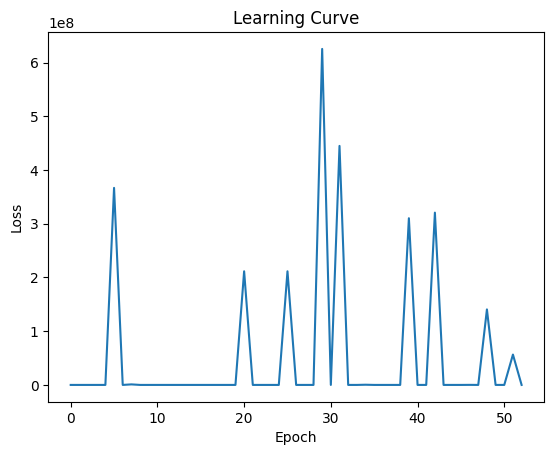

In [ ]:
plt.plot(loss_list)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
embedded_3d = tsne.fit_transform(embeddings2)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embedded_2d = tsne.fit_transform(embeddings2)

In [ ]:
np.save('/content/drive/MyDrive/SocioSent/embedded_2d.npy', embedded_2d)
np.save('/content/drive/MyDrive/SocioSent/embedded_3d.npy', embedded_3d)

In [ ]:
embedded_3d = np.load('/content/drive/MyDrive/SocioSent/embedded_3d.npy')
embedded_2d = np.load('/content/drive/MyDrive/SocioSent/embedded_2d.npy')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SocioSent/labels.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
import collections

labels = []#np.zeros([1,Xs.shape[1]])
embeds = []
embeds_3d = []
embeds_2d = []
n = 120
len = df.shape[0]
overlap = 0.5
step_size = 10

# count = collections.Counter(my_list)
# most_common = count.most_common(1)[0][0]

for i in range(0, 120):
  idx = 0
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])

for i in range(120, len-120):
  step = i // step_size
  idx = step - 4
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])

for i in range(len-120, len):
  # step = len - 120 // step_size
  idx = len - 120
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = 0 #count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[2,:])
  embeds_2d.append(embedded_2d[2,:])
  embeds_3d.append(embedded_3d[2,:])

# for _ in range(int(n*0.25)):
#     labels.append(cluster_labels[0])
#     embeds.append(embeddings2[0,:])

# for i in range(graph_num):
#   for _ in range(int(n*0.5)):
#     labels.append(cluster_labels[i])
#     embeds.append(embeddings2[i,:])

# for _ in range(int(50)):
#     labels.append(cluster_labels[graph_num-1])
#     embeds.append(embeddings2[graph_num-1,:])

  # labels[idx*n:(idx*n+n)] = la*np.ones([1,graph_num])
# labels[idx:idx+n] = la

embeds_3d = np.array(embeds_3d)
embeds_2d = np.array(embeds_2d)

In [ ]:
print(labels[1000:1500])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/SocioSent/frame_lablels.csv', index=False)

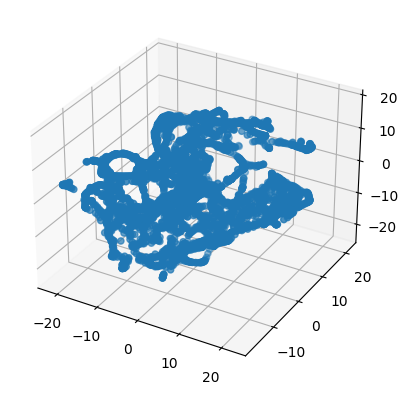

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
# tsne = TSNE(n_components=3, perplexity=30, random_state=0)
# embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2])#, #c=cluster_labels)
plt.show()


In [ ]:
embeds = np.array(embeds)

**save as CSV files:**

In [ ]:
np.savetxt('/content/drive/MyDrive/SocioSent/embeds_3d.csv', embeds_3d, delimiter=',')
np.savetxt('/content/drive/MyDrive/SocioSent/embeds_2d.csv', embeds_2d, delimiter=',')
np.savetxt('/content/drive/MyDrive/SocioSent/labels.csv', labels, delimiter=',')